# Optimizing a chemical reaction

As a very simple example of optimizing a chemical reaction, we try to find the
mix of universal indicator, acid and base that gives the best green color. While this
is a very simple experiment, it shows the general approach one would follow in
optimizing a chemical reaction according to yield or purity.

We have made a full factorial mix of different levels of indicator while varying the percentage of acid (`V(acid)/(V(acid) + V(base))*100 %`),
and measured the resulting color:

![Full factorial indicator and acid mix in a plate](../ProcessOptimizer/model_systems/data/color_pH_image.jpg)

When in the lab, you would normally do one experiment at a time. To simulate this, we have
made it possible to look up the result from any recipe. In other words, we can do theoretical
experiments that mimic what you would see if you were to
do laboratory experiments one at a time. This behavior is
captured by the model system color_pH.

We first set up the parameter space:

In [1]:
import ProcessOptimizer as po

search_space = [
       po.Integer(30,85, name="pct_acid"),
       po.Integer(5,40, name="vol_indicator")
       ]


We can then set up the processOptimizer:

In [2]:
opt = po.Optimizer(search_space, n_initial_points=4)

We can now ask the optimizer to suggest the next recipe to try, and use the
model system to simulate following the recipe and telling us how good
the result is:

In [3]:
# Get the first suggested experiment
next_recipe = opt.ask()
print(("Next suggested experiment has "
      + str(next_recipe[0])
      + " percent acid and "
      + str(next_recipe[1])
      + " μL indicator."))



Next suggested experiment has 79 percent acid and 36 μL indicator.


## Using the model system separately

The model system has a method called `get_score()` which simulates following the recipe,
measuring the resulting color, and evaluating how close it is to the wanted color.

In a lab setting, you would run the experiment instead, and record the results.

We also start saving the recipes simulated and their resulting qualities.

In [4]:
model_system = po.model_systems.color_pH
# Run the experiment and get the result
quality = model_system.get_score(next_recipe)

recipe_and_result_list = [(next_recipe, quality)]

print(f"Following the recipe lead to a quality of {quality:.2f}")

Following the recipe lead to a quality of 50.82


Now, we can tell the optimizer about the recipe we just "followed".

In [5]:
result = opt.tell(next_recipe, quality)

We can keep doing this for a few runs.

In [6]:
for i in range(7):
    next_recipe = opt.ask()
    quality = model_system.get_score(next_recipe)
    recipe_and_result_list.append((next_recipe, quality))
    result = opt.tell(next_recipe, quality)

Finally, we can plot the result object to inspect the model.

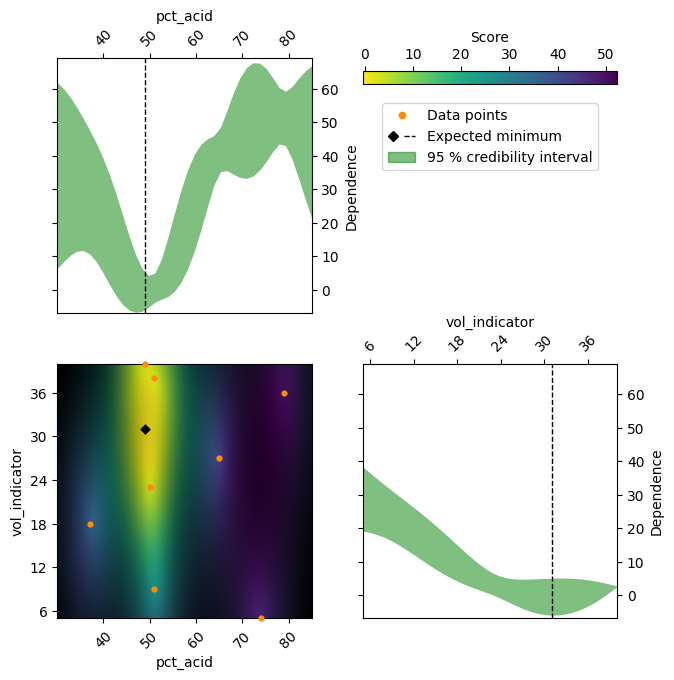

In [7]:
# Make additional plot with measurement uncertainty

po.plot_objective(result,
                  pars = 'expected_minimum',
                  plot_options = {"interpolation": "bicubic"},
                  );

The 2D plot shows the model when two parameters are changed. In this example, there are only two parameters, so that is the entire model. In models with more parameters, the dependency on each pair of variables would be shown as separate 2D plots. This plotting type scales to any number of parameters, including real, integer and categorical parameters.

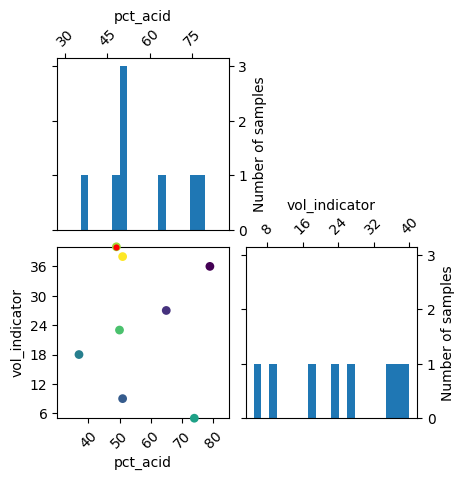

In [10]:
po.plot_evaluations(result);

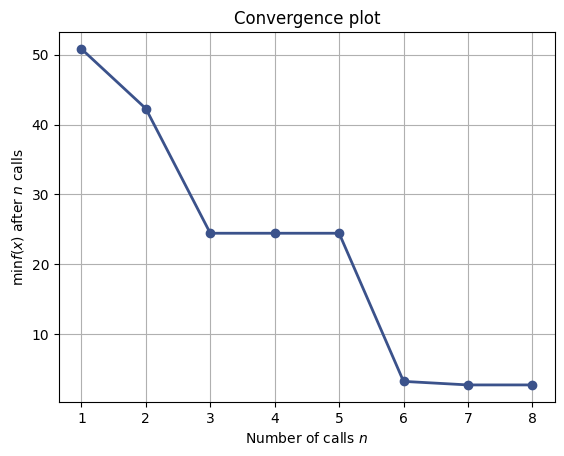

In [11]:
po.plot_convergence(result);

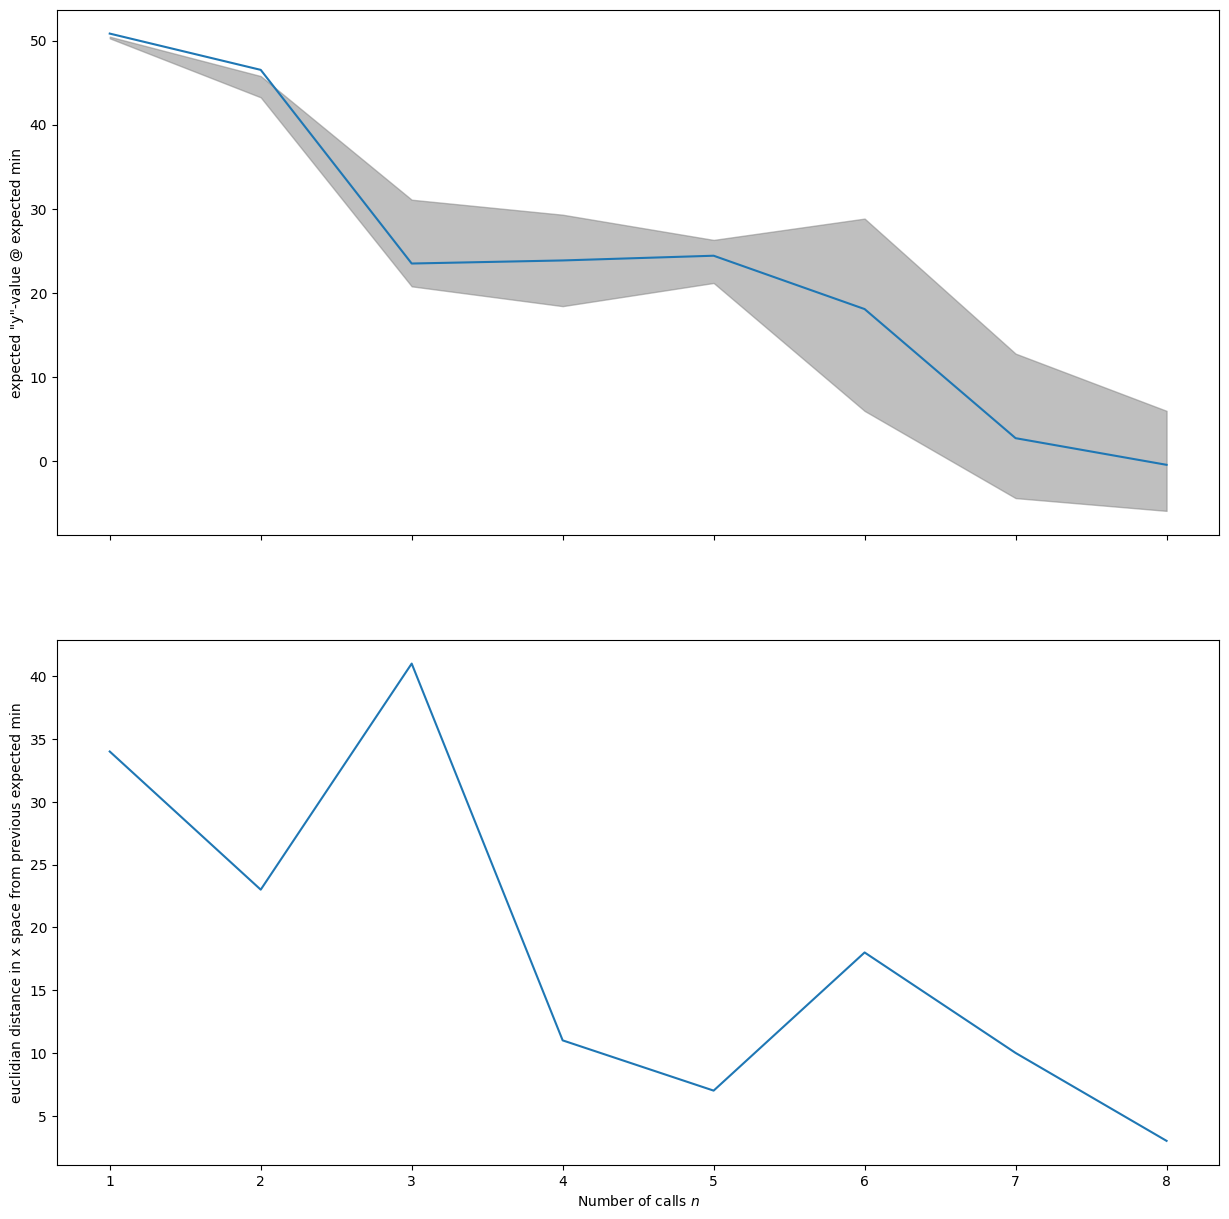

In [12]:
po.plot_expected_minimum_convergence(result);

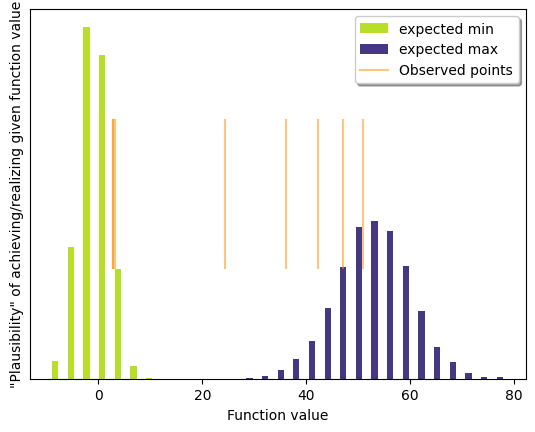

In [13]:
po.y_coverage(result, return_plot=True);

We can now find the expected minimum of the model:

In [ ]:
expected_minimum = po.expected_minimum(result)
print(
    f"The expected minimum is {expected_minimum[0][0]} percent acid and "
    f"{expected_minimum[0][1]} μL indicator. It has an expected quality of "
    f"{expected_minimum[1]}."
)

The expected minimum is 49 percent acid and 31 μL indicator. It has an expected quality of -0.43872456198240073.


The true minimum is at 50 percent acid and 30 μL indicator, but since the experimental
mixtures are only made at whole multiples of 5 percent acid and 5 μL indicator, 49 percent
acid and 31 μL indicator gives the same quality.

The experimental quality at the true minimum is 0 by definition, so the model estimates a
bit better quality at the minimum.

## Table with overview of results

We can now make a table with an overview of the tested recipes and their results. Rember, lower score is better:

In [ ]:
for recipe, quality in recipe_and_result_list:
    print({
        "pct_acid": recipe[0],
        "vol_indicator": recipe[1],
        "score": round(quality,1)
    })


{'pct_acid': 79, 'vol_indicator': 36, 'score': 50.8}
{'pct_acid': 65, 'vol_indicator': 27, 'score': 42.3}
{'pct_acid': 51, 'vol_indicator': 9, 'score': 24.5}
{'pct_acid': 37, 'vol_indicator': 18, 'score': 36.2}
{'pct_acid': 74, 'vol_indicator': 5, 'score': 47.1}
{'pct_acid': 50, 'vol_indicator': 23, 'score': 3.3}
{'pct_acid': 49, 'vol_indicator': 40, 'score': 2.8}
{'pct_acid': 51, 'vol_indicator': 38, 'score': 2.8}
